# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\all_data


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_reg1.ant' 

data_file01 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.1.csv'
data_file02 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.2.csv'
data_file03 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.3.csv'
data_file04 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.4.csv'
data_file05 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.5.csv'
data_file10 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_1.01.csv'

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

9.995861419348e-16

In [ ]:
BMCA_obj01 = BMCA.BMCA(Teusink_ant, data_file01)
BMCA_obj02 = BMCA.BMCA(Teusink_ant, data_file02)
BMCA_obj03 = BMCA.BMCA(Teusink_ant, data_file03)
BMCA_obj04 = BMCA.BMCA(Teusink_ant, data_file04)
BMCA_obj05 = BMCA.BMCA(Teusink_ant, data_file05)
BMCA_obj10 = BMCA.BMCA(Teusink_ant, data_file10)


In [5]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,431.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,674.6


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,306.6


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,176.5


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,122.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,030.3


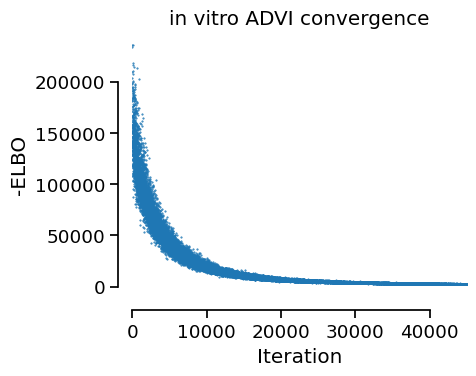

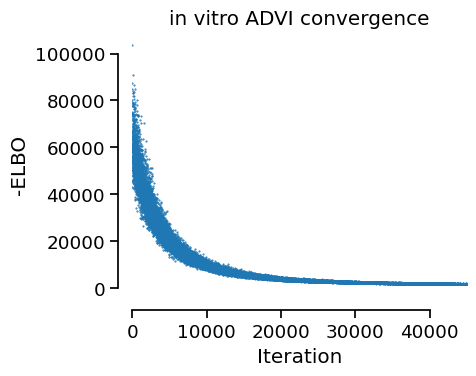

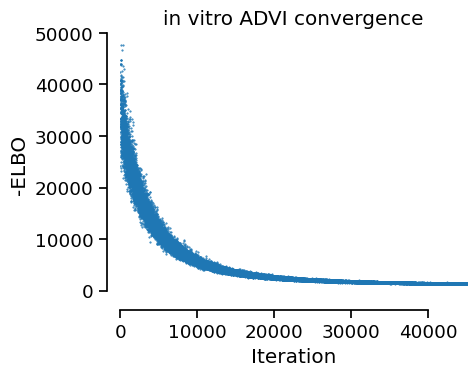

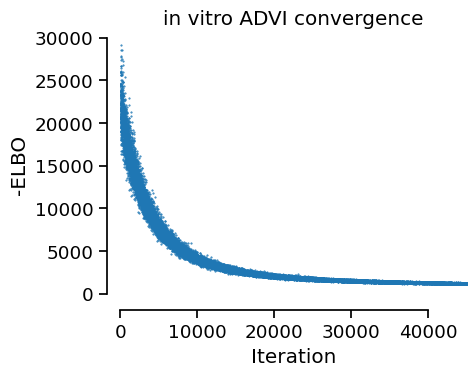

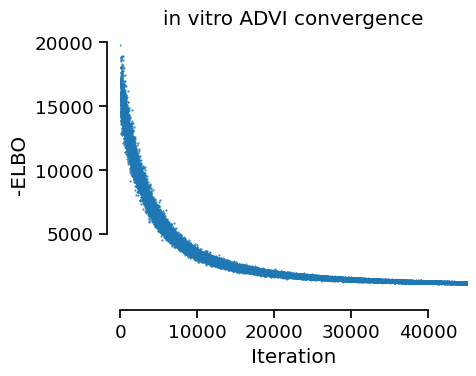

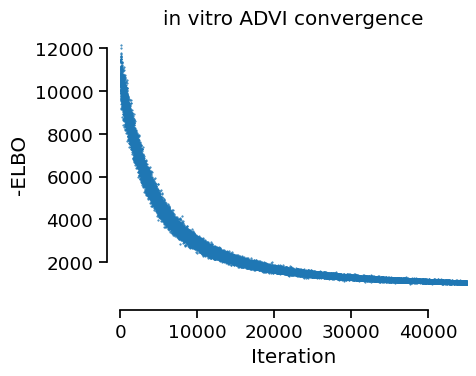

In [6]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)
trace10 = run_ADVI(BMCA_obj10)


In [7]:
# Ey_advi = (trace['posterior']['Ey']).to_numpy().squeeze()
ExTrace_01 = (trace01['posterior']['Ex']).to_numpy().squeeze()
ExTrace_02 = (trace02['posterior']['Ex']).to_numpy().squeeze()
ExTrace_03 = (trace03['posterior']['Ex']).to_numpy().squeeze()
ExTrace_04 = (trace04['posterior']['Ex']).to_numpy().squeeze()
ExTrace_05 = (trace05['posterior']['Ex']).to_numpy().squeeze()
ExTrace_10 = (trace10['posterior']['Ex']).to_numpy().squeeze()


In [8]:
medEx_01 = np.median(ExTrace_01, axis=0)
medEx_02 = np.median(ExTrace_02, axis=0)
medEx_03 = np.median(ExTrace_03, axis=0)
medEx_04 = np.median(ExTrace_04, axis=0)
medEx_05 = np.median(ExTrace_05, axis=0)
medEx_10 = np.median(ExTrace_10, axis=0)


In [9]:
# first regulator, PYR on PFK
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['vPFK']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['vPFK']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
G6P,0.000000,0.016766,0.010918,0.008740,0.002580,0.000647,0.000233
TRIO,0.000000,0.104122,0.029566,0.017417,0.008247,-0.000610,-0.007189
ACE,0.000000,0.155679,0.058209,0.014788,-0.001530,0.000295,-0.006548
P3G,0.000000,0.007696,0.002937,0.003636,0.009079,0.003063,-0.003580
PEP,0.000000,0.000705,-0.012645,0.005871,-0.007102,-0.004294,-0.002116
GLCi,0.000000,-0.008817,0.009557,0.011220,0.003729,0.003565,0.007302
F6P,1.013324,0.129083,0.243145,0.267251,0.306523,0.363342,0.985353
BPG,0.000000,0.023382,0.011576,0.000998,-0.001707,0.010121,0.001974
PYR,-0.680728,-0.005698,-0.029792,-0.021240,-0.017216,-0.010789,-0.006040
F16P,-0.213181,-0.006312,0.002926,0.029122,0.048346,-0.007036,-0.777220


In [10]:
# second regulator, P3G on PGI
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['vPGI']]
for i in [medEx_01, medEx_02, medEx_03, medEx_04, medEx_05, medEx_10]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['vPGI']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x'], axis='columns') 

,gt,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
G6P,1.850016,1.802914,1.488595,1.622115,1.471170,1.599428,0.951072
TRIO,0.000000,0.015783,0.015832,0.011594,0.007483,0.004010,0.002913
ACE,0.000000,0.021395,0.012427,-0.004097,-0.002119,-0.008685,0.007255
P3G,0.000000,0.003250,0.011964,0.008402,0.000477,0.006761,0.000334
PEP,0.000000,0.001072,0.003316,0.002945,0.001222,0.003847,-0.000993
GLCi,0.000000,0.004644,0.001442,-0.001891,0.001101,-0.000905,0.006161
F6P,-1.472593,-1.411963,-1.158544,-1.277176,-1.154564,-1.241424,-0.906969
BPG,0.000000,0.007569,0.017357,0.006801,-0.003238,0.002737,-0.004559
PYR,0.000000,0.011000,-0.012812,-0.008547,-0.003177,-0.001067,-0.004578
F16P,0.000000,0.005948,0.007509,0.009462,-0.001114,0.010004,0.000095


## Calculating FCCs

In [11]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [12]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [13]:
postFCC01 = estimate_CCs(BMCA_obj01, ExTrace_01)
postFCC02 = estimate_CCs(BMCA_obj02, ExTrace_02)
postFCC03 = estimate_CCs(BMCA_obj03, ExTrace_03)
postFCC04 = estimate_CCs(BMCA_obj04, ExTrace_04)
postFCC05 = estimate_CCs(BMCA_obj05, ExTrace_05)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)


In [14]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
pt_labels = ['0.1x','0.2x','0.3x','0.4x','0.5x', '1.01x']

In [15]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [16]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vGLK,0.1x,-1.835989,0.006859,0.027274,0.278798,0.223750,-0.001188,-0.003420,-0.003729,-0.005410,-0.004990,-0.008356,-0.001477,-0.005301,0.351660,-0.013508,-0.007101
vPGI,0.1x,0.073544,-1.968417,-0.012918,-0.132051,1.104337,-0.000282,-0.017303,-0.016632,-0.018738,-0.015356,-0.024136,-0.005495,-0.027192,0.152549,-0.069295,-0.028391
vGLYCO,0.1x,0.198709,-0.007772,-1.036257,-0.370630,-0.255105,-0.001617,0.003344,0.001872,0.001576,0.000111,-0.000749,-0.001431,0.005829,0.431150,0.014855,0.003946
vTreha,0.1x,0.217704,-0.006721,-0.039477,-1.403547,-0.282683,-0.002377,0.004434,0.003918,0.001993,0.000685,0.000216,0.000088,0.006955,0.469881,0.017723,0.004837
vPFK,0.1x,0.073544,0.031583,-0.012918,-0.132051,-0.895663,-0.000282,-0.017303,-0.016632,-0.018738,-0.015356,-0.024136,-0.005495,-0.027192,0.152549,-0.069295,-0.028391


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_17672\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

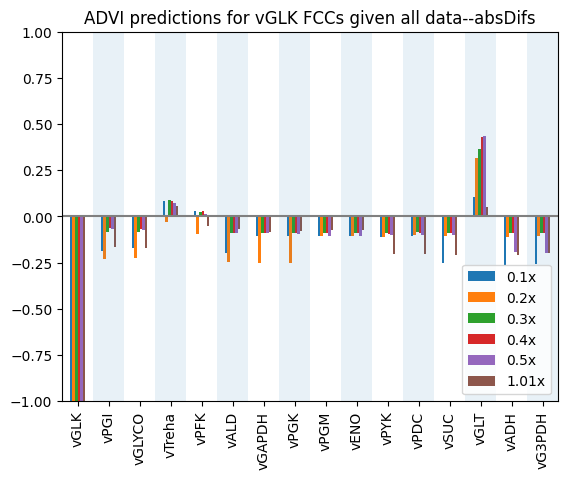

<Figure size 1600x1000 with 0 Axes>

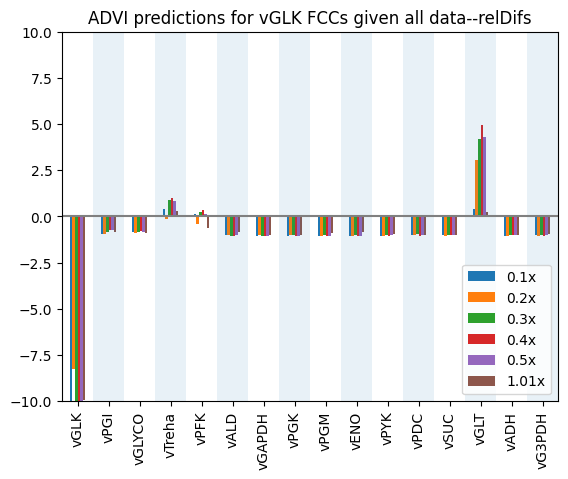

<Figure size 1600x1000 with 0 Axes>

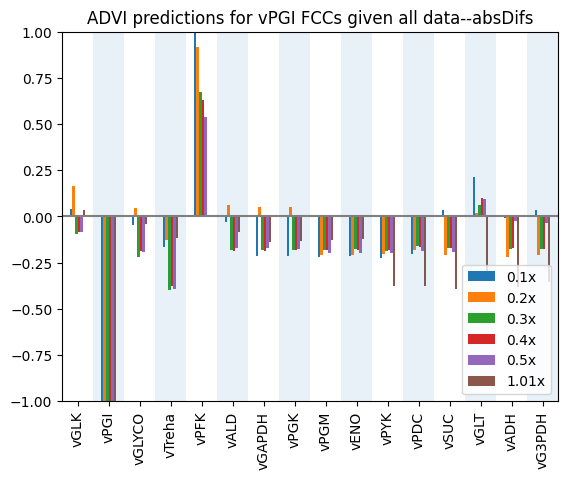

<Figure size 1600x1000 with 0 Axes>

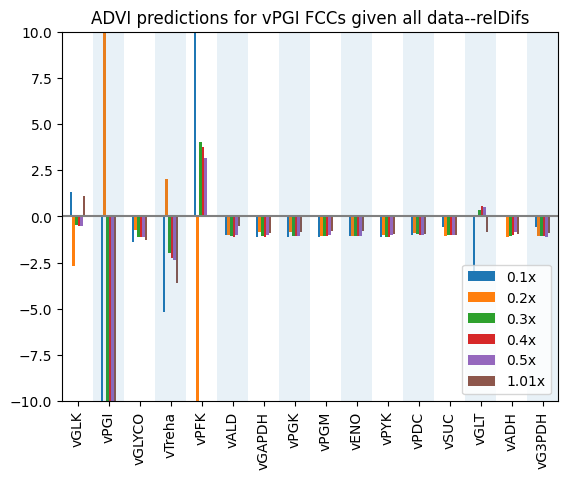

<Figure size 1600x1000 with 0 Axes>

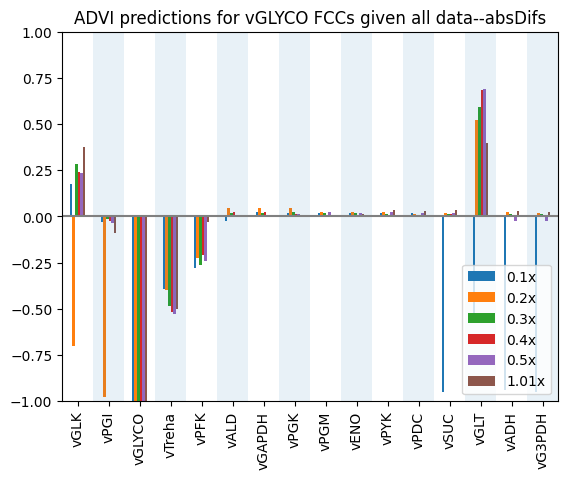

<Figure size 1600x1000 with 0 Axes>

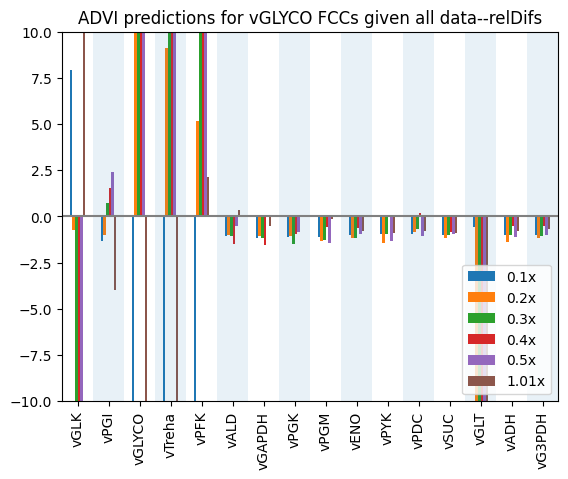

<Figure size 1600x1000 with 0 Axes>

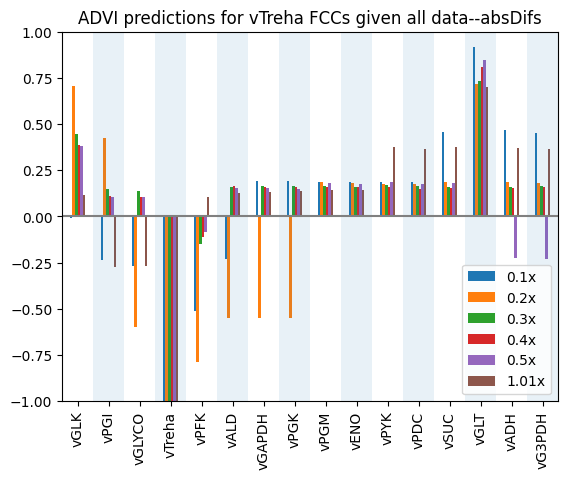

<Figure size 1600x1000 with 0 Axes>

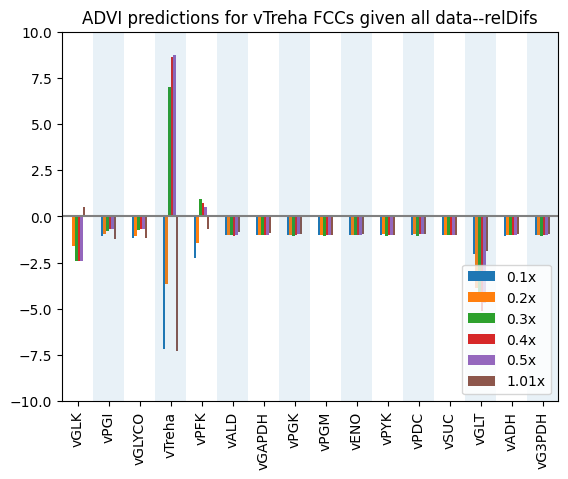

<Figure size 1600x1000 with 0 Axes>

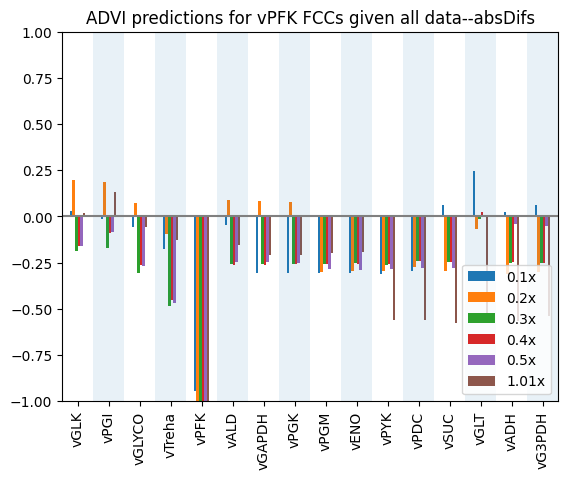

<Figure size 1600x1000 with 0 Axes>

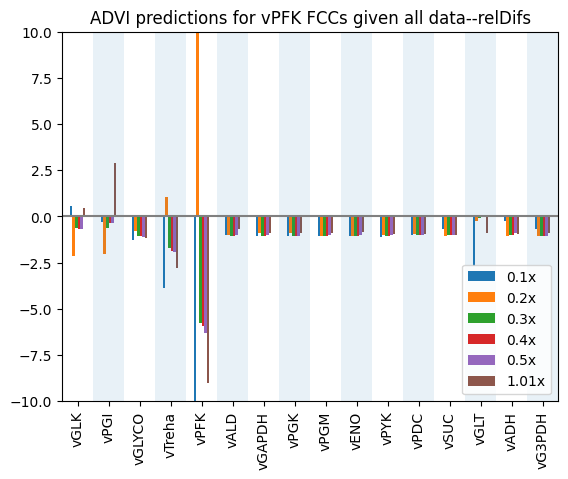

<Figure size 1600x1000 with 0 Axes>

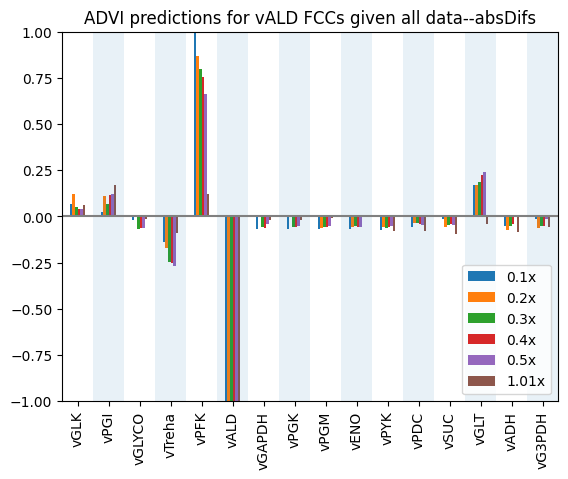

<Figure size 1600x1000 with 0 Axes>

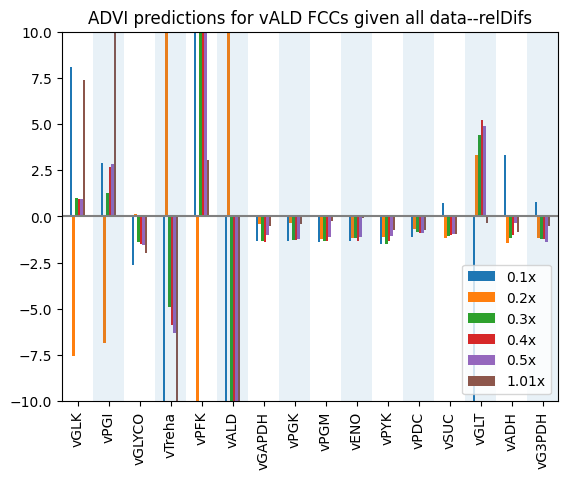

<Figure size 1600x1000 with 0 Axes>

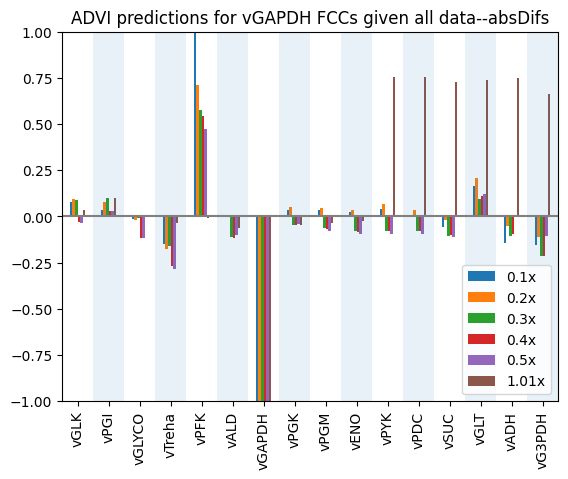

<Figure size 1600x1000 with 0 Axes>

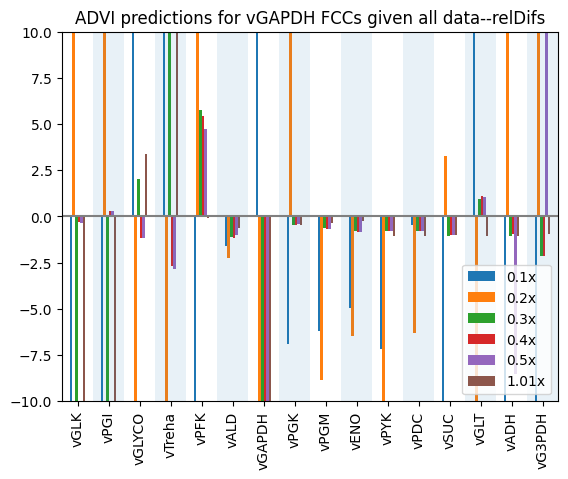

<Figure size 1600x1000 with 0 Axes>

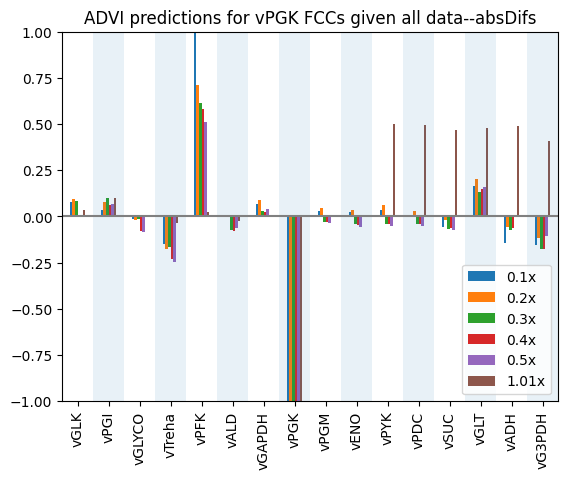

<Figure size 1600x1000 with 0 Axes>

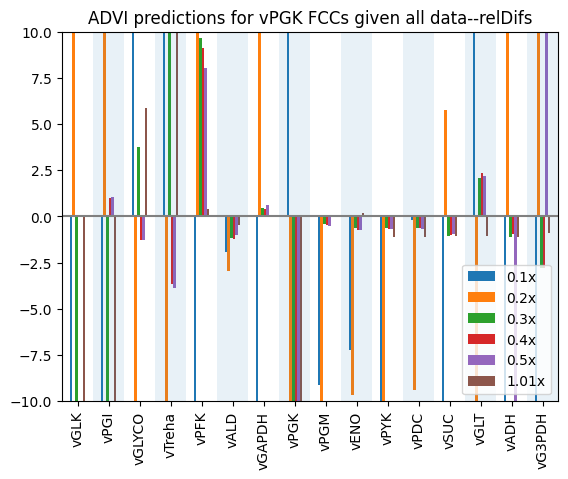

<Figure size 1600x1000 with 0 Axes>

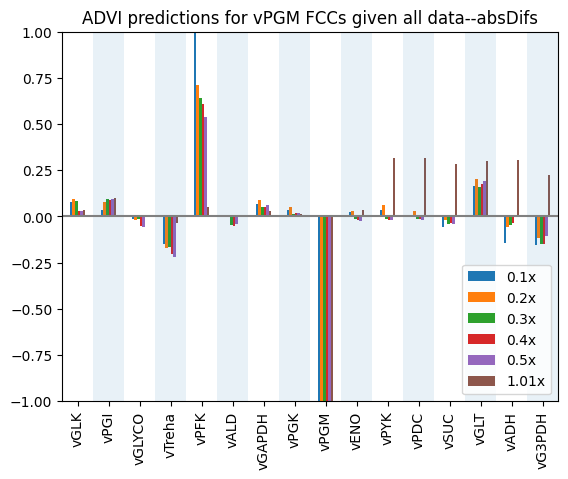

<Figure size 1600x1000 with 0 Axes>

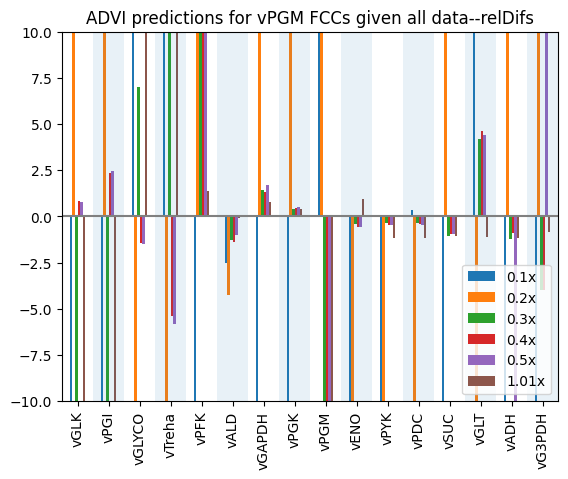

<Figure size 1600x1000 with 0 Axes>

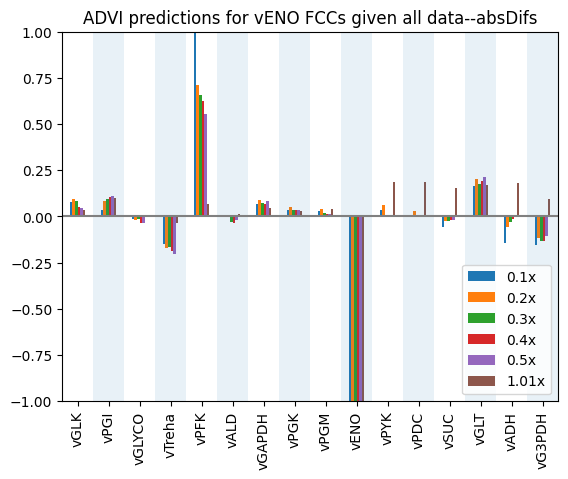

<Figure size 1600x1000 with 0 Axes>

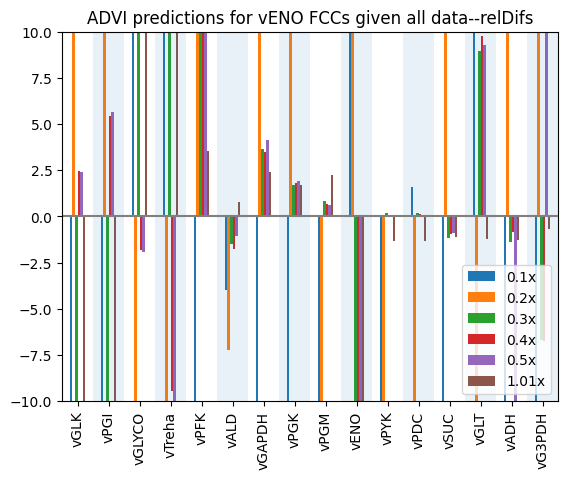

<Figure size 1600x1000 with 0 Axes>

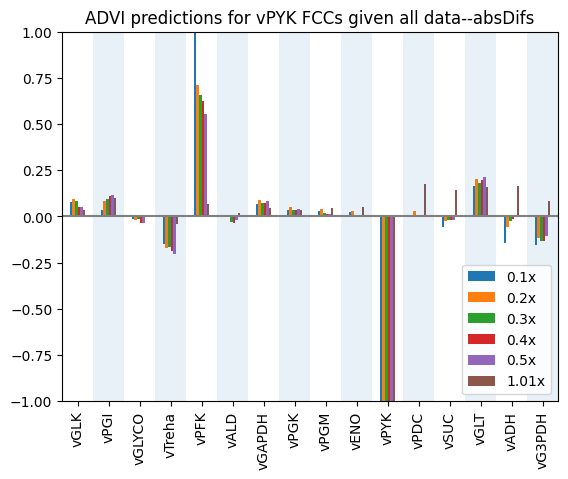

<Figure size 1600x1000 with 0 Axes>

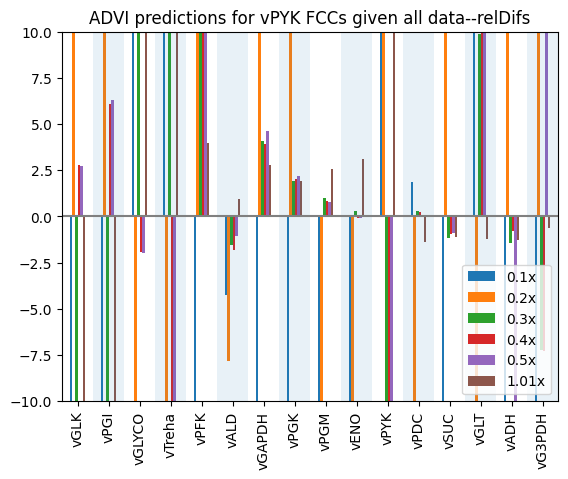

<Figure size 1600x1000 with 0 Axes>

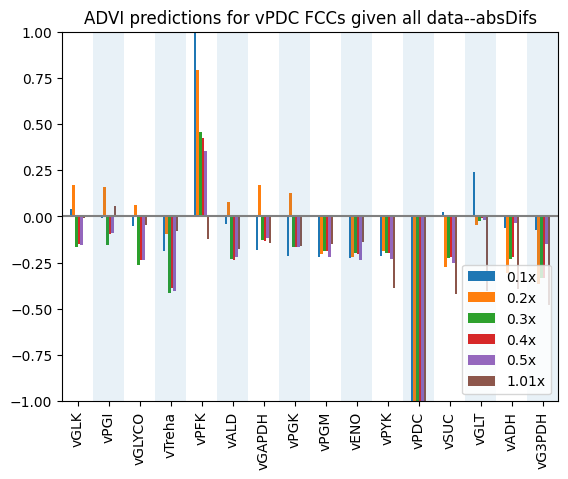

<Figure size 1600x1000 with 0 Axes>

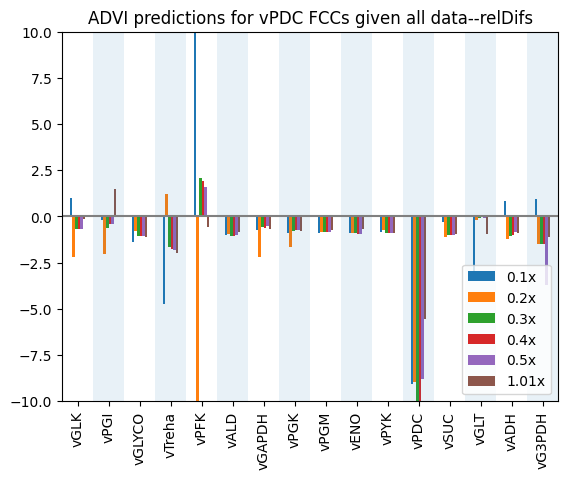

<Figure size 1600x1000 with 0 Axes>

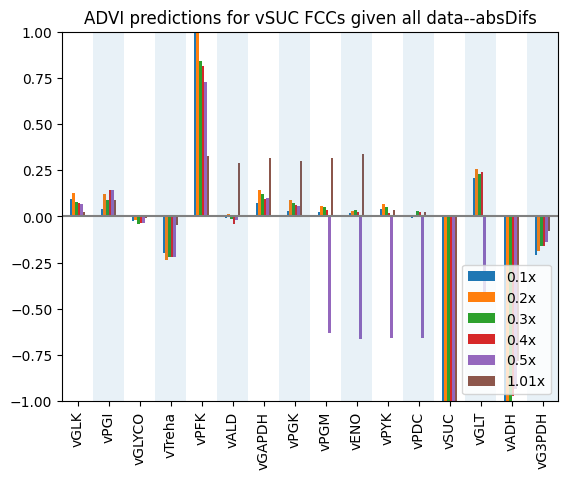

<Figure size 1600x1000 with 0 Axes>

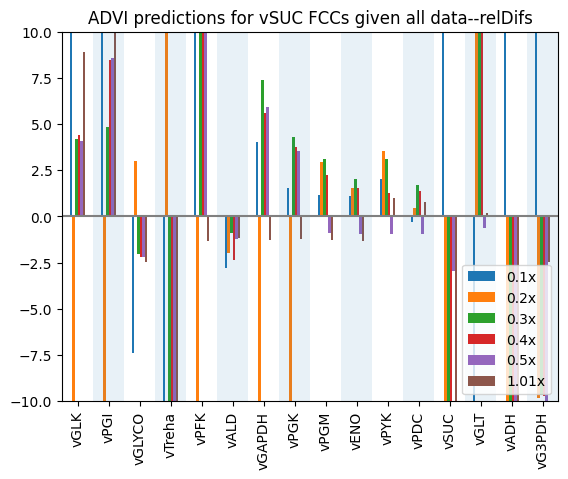

<Figure size 1600x1000 with 0 Axes>

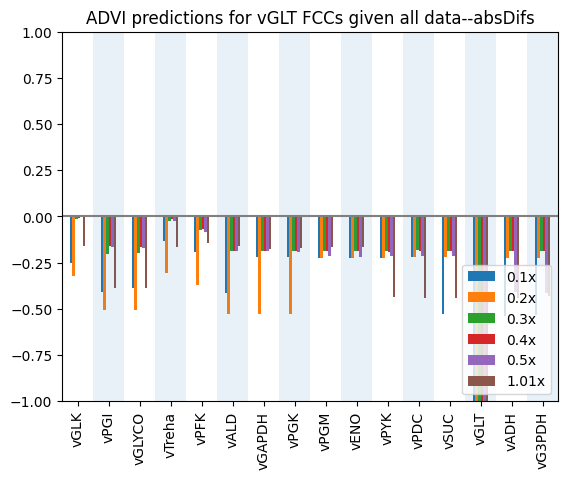

<Figure size 1600x1000 with 0 Axes>

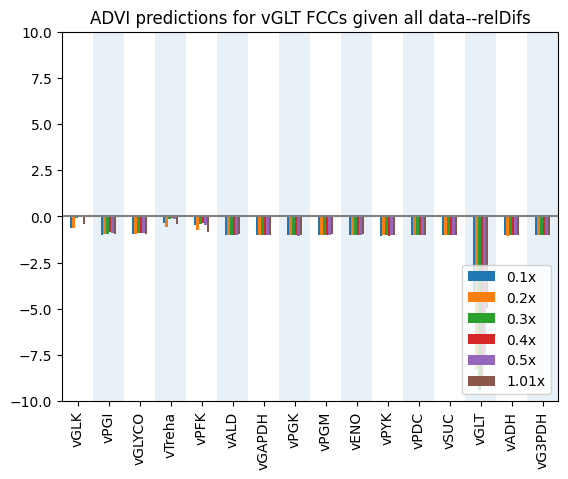

<Figure size 1600x1000 with 0 Axes>

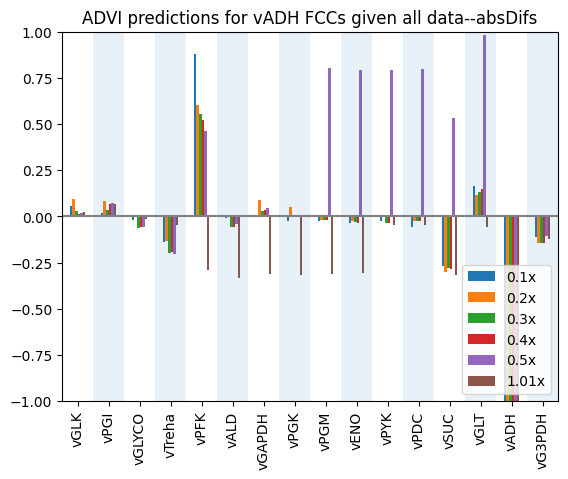

<Figure size 1600x1000 with 0 Axes>

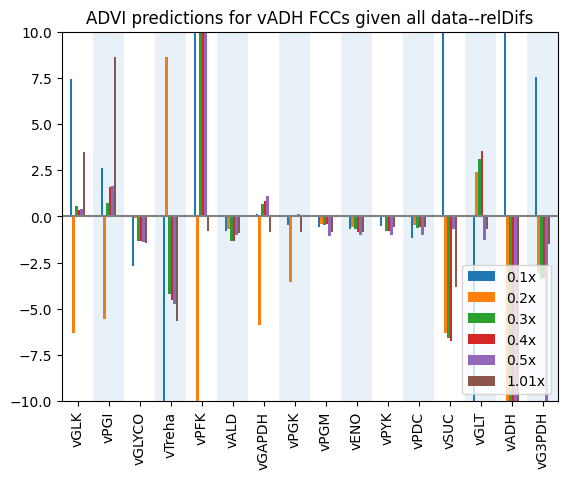

<Figure size 1600x1000 with 0 Axes>

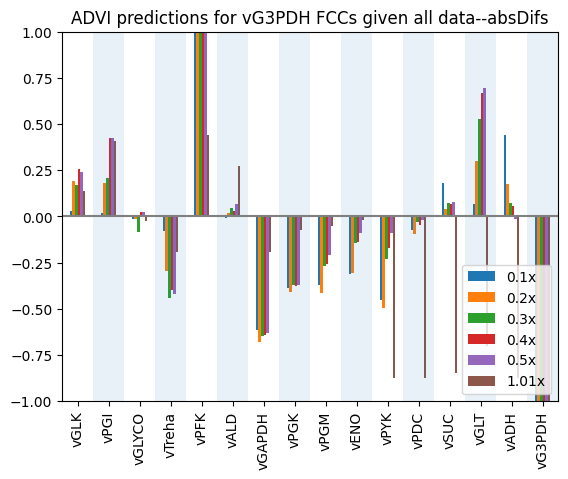

<Figure size 1600x1000 with 0 Axes>

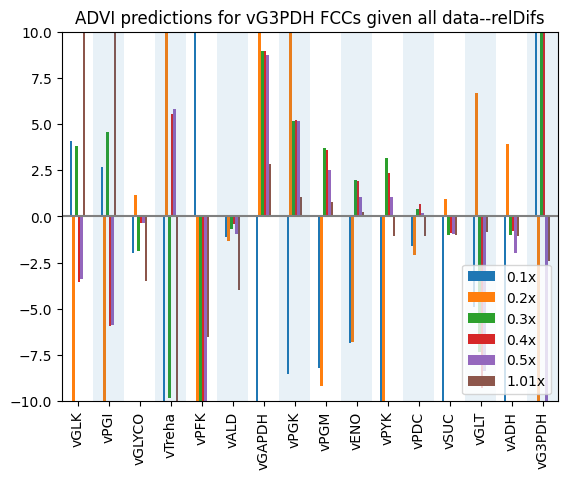

In [17]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [18]:
plt.close("all")

## Evaluating FCC ranking

In [19]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [20]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [21]:
rxn_FCCs = [postFCC01,postFCC02,postFCC03,postFCC04,postFCC05, postFCC10]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [22]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')

,0.1x,0.2x,0.3x,0.4x,0.5x,1.01x
vGLK,2,3,2,3,2,3
vPGI,1,2,1,2,1,1
vGLYCO,1,2,1,2,1,3
vTreha,2,3,2,3,2,2
vPFK,1,1,1,2,1,1
vALD,1,2,1,2,1,1
vGAPDH,1,2,1,2,1,1
vPGK,1,2,1,2,1,1
vPGM,1,2,1,2,1,1
vENO,1,2,1,2,1,1


In [23]:
topThreeCheckdf.sum(axis=0)

0.1x     19
0.2x     33
0.3x     20
0.4x     34
0.5x     20
1.01x    25
dtype: int64